# Mask at stack Landsat 8 images

This notebook contains code to mask and stack Landsat 8 images.  Masking is done using the QA Pixels file, which is generated using the CFMask algorithm.  The only block you have to edit is the one which sets the location of the files. There is a block which shows you the mask before you write the files, allowing you to change it if needed.  

FYI: Binary codes for the QA Pixels file (which uses the CFMask algorithm).

    bit                    15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 0

    Fill                   0  0  0  0  0  0  0 0 0 0 0 0 0 0 0 1
    Dilated cloud          0  0  0  0  0  0  0 0 0 0 0 0 0 0 1 0
    High conf cirrus       0  0  0  0  0  0  0 0 0 0 0 0 0 1 0 0
    High conf cloud        0  0  0  0  0  0  0 0 0 0 0 0 1 0 0 0
    High conf cloud shadow 0  0  0  0  0  0  0 0 0 0 0 1 0 0 0 0
    High conf snow         0  0  0  0  0  0  0 0 0 0 1 0 0 0 0 0 
    Clear                  0  0  0  0  0  0  0 0 0 1 0 0 0 0 0 0 
    Water                  0  0  0  0  0  0  0 0 1 0 0 0 0 0 0 0

    Cloud confidence       
        low                0  0  0  0  0  0  1 0 0 0 0 0 0 0 0 0
        med                0  0  0  0  0  0  0 1 0 0 0 0 0 0 0 0 
        high               0  0  0  0  0  0  1 1 0 0 0 0 0 0 0 0
    
    Cloud Shadow confidence       
        low                0  0  0  0  1  0  0 0 0 0 0 0 0 0 0 0
        high               0  0  0  0  1  1  0 0 0 0 0 0 0 0 0 0
    
    Snow/Ice confidence       
        low                0  0  1  0  0  0  0 0 0 0 0 0 0 0 0 0
        high               0  0  1  1  0  0  0 0 0 0 0 0 0 0 0 0  
    
    Cirrus confidence       
        low                1  0  0  0  0  0  0 0 0 0 0 0 0 0 0 0
        high               1  1  0  0  0  0  0 0 0 0 0 0 0 0 0 0

np.bitwise_and function finds those bits that indicate "true" in the QA array given the condition, such as water or clouds.

np.right_shift moves the resulting '1' or '0' (or pixels in which the condition is true or false, respectively) to the first bit position, enabling creation of a binary mask

Resources:
https://www.usgs.gov/core-science-systems/nli/landsat/landsat-collection-2-quality-assessment-bands

In [1]:
import os
import rasterio
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

In [14]:
### This is the only block which needs edited ###

# Directory in which band data exists
os.chdir('.../LC08_L2SP_024029_20190710_20200827_02_T1')

# Select spectral bands desired to mask and stack.  PUT THEM IN THE ORDER OF STACKING.
bands = ['LC08_L2SP_024029_20190710_20200827_02_T1_SR_B2.TIF',
         'LC08_L2SP_024029_20190710_20200827_02_T1_SR_B3.TIF',
         'LC08_L2SP_024029_20190710_20200827_02_T1_SR_B4.TIF',
         'LC08_L2SP_024029_20190710_20200827_02_T1_SR_B5.TIF',
         'LC08_L2SP_024029_20190710_20200827_02_T1_SR_B6.TIF',
         'LC08_L2SP_024029_20190710_20200827_02_T1_SR_B7.TIF'
        ]

# Name (or filepath) to the QA_PIXEL band
qa_fp = 'LC08_L2SP_024029_20190710_20200827_02_T1_QA_PIXEL.TIF'

# Select masking items from: ['cloud_d', 'cirrus', 'cloud', 'cloud_sh', 'snow, water']
masking_items = ['cloud_d', 'cirrus', 'cloud', 'cloud_sh','water']

# To mask everything but clear, leave masking_items empty and set this to True.
# This will create a mask using the clear pixels, and then invert it so everything not clear
# is masked out.  Note: Clear pixels with water and snow are kept.
clr_only = False 

# Name you want the masked and stacked image to have
out_file_name = 'LC08_L2SP_024029_20190710_20200827_02_T1_SR_masked_stacked.tif'

In [15]:
qa = rasterio.open(qa_fp)
qa_band = qa.read(1)

cloud_d = '0000000000000010' # Cloud dilation
cirrus =  '0000000000000100' # High confidence that cirrus exist
cloud =   '0000000000001000' # High confidence that a cloud exists
cloud_sh ='0000000000010000' # High confidence that a cloud exists
snow =    '0000000000100000' # High confidence that snow/ice exists
clear =   '0000000001000000' # Pixel is likely clear
water =   '0000000010000000' # High confidence that water exists

In [18]:
if clr_only == True:
    clr = np.right_shift(np.bitwise_and(qa_band, int(clear, 2)), 6)
    full_mask = clr==0  #create a mask using 0 becuase here it means "not clear"
    
else:
    if 'cloud_d' in masking_items:
        cld_d = np.right_shift(np.bitwise_and(qa_band, int(cloud_d, 2)), 1)
    else:
        cld_d = np.zeros(shape=qa_band.shape)
        
    if 'cirrus' in masking_items:
        cir = np.right_shift(np.bitwise_and(qa_band, int(cirrus, 2)), 2)
    else:
        cir = np.zeros(shape=qa_band.shape)

    if 'cloud' in masking_items:
        cld = np.right_shift(np.bitwise_and(qa_band, int(cloud, 2)), 3)
    else:
        cld = np.zeros(shape=qa_band.shape)
        
    if 'cloud_sh' in masking_items:
        cld_sh = np.right_shift(np.bitwise_and(qa_band, int(cloud_sh, 2)), 4)
    else:
        cld_sh = np.zeros(shape=qa_band.shape)    

    if 'snow' in masking_items:
        sno = np.right_shift(np.bitwise_and(qa_band, int(snow, 2)), 5)
    else:
        sno = np.zeros(shape=qa_band.shape)    

    if 'water' in masking_items:
        wat = np.right_shift(np.bitwise_and(qa_band, int(water, 2)), 7)
    else:
        wat = np.zeros(shape=qa_band.shape)          

    full_mask=(cld_d==1)|(cir==1)|(cld==1)|(cld_sh==1)|(sno==1)|(wat==1)

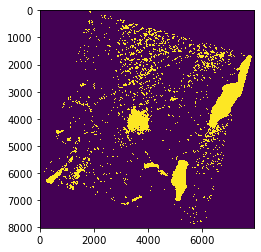

In [19]:
plt.imshow(full_mask)

In [20]:
masked_img = np.zeros(shape=[qa_band.shape[0], qa_band.shape[1], len(bands)], dtype='uint16')

for num, band in enumerate(bands):
    img = rasterio.open(band)
    data = img.read(1)
    nodata = img.nodata

    tmp = ma.masked_array(data, full_mask)
    arr = ma.filled(tmp, nodata)
    masked_img[:, :, num] = arr

In [21]:
src = rasterio.open(bands[1]) 

with rasterio.Env():
    profile = src.profile
    profile.update({'count':len(bands)})

    with rasterio.open(out_file_name, 'w', **profile) as dst: 
        for i in range(1, len(bands)+1):
            dst.write(masked_img[:, :,i-1], i) 